In [1]:
import yfinance as yf

In [224]:


# Define the ticker symbol for USD/GBP exchange rate
ticker_symbol = 'USDSEK=X'

# Define the start and end dates for the historical data


# Retrieve the historical exchange rate data
data = yf.download(ticker_symbol)


[*********************100%***********************]  1 of 1 completed


In [225]:
df = data.Close
print(df)

Date
2001-07-16    10.80500
2001-07-17    10.72400
2001-07-18    10.55980
2001-07-19    10.62950
2001-07-20    10.65610
                ...   
2023-05-09    10.17080
2023-05-10    10.18891
2023-05-11    10.21660
2023-05-12    10.31979
2023-05-15    10.33990
Name: Close, Length: 5506, dtype: float64


In [226]:
import pandas as pd
import numpy as np

# Load the historical exchange rates data
# Define the number of lagged exchange rates to include
num_lags = 10
df = data.Close
df_lag = pd.DataFrame(
                np.zeros((len(df), num_lags))        
                )
col_name = []
# Create lagged exchange rate columns
for i in range( num_lags ):
    col_name.append( 'Close-' + str(i) )
    df_lag.iloc[:,i] = df.shift((i+1)).to_numpy()

# Drop rows with missing values (due to lagged exchange rates)
df_lag.dropna(inplace=True)
print(df_lag)
# Split the data into input features (X) and output (y)
X = df_lag.to_numpy()  # lagged exchange rate columns
y = df.to_numpy()[len(df)-len(X):]   # current exchange rate column

print(X.shape)
print(y.shape)

             0         1         2         3         4         5         6  \
10    10.55820  10.57050  10.61370  10.66380  10.70470  10.65610  10.62950   
11    10.57960  10.55820  10.57050  10.61370  10.66380  10.70470  10.65610   
12    10.58860  10.57960  10.55820  10.57050  10.61370  10.66380  10.70470   
13    10.54090  10.58860  10.57960  10.55820  10.57050  10.61370  10.66380   
14    10.42990  10.54090  10.58860  10.57960  10.55820  10.57050  10.61370   
...        ...       ...       ...       ...       ...       ...       ...   
5501  10.17420  10.21905  10.25430  10.30280  10.32753  10.25896  10.28155   
5502  10.17080  10.17420  10.21905  10.25430  10.30280  10.32753  10.25896   
5503  10.18891  10.17080  10.17420  10.21905  10.25430  10.30280  10.32753   
5504  10.21660  10.18891  10.17080  10.17420  10.21905  10.25430  10.30280   
5505  10.31979  10.21660  10.18891  10.17080  10.17420  10.21905  10.25430   

             7         8         9  
10    10.55980  10.72400  

In [227]:
import torch
import matplotlib.pyplot as plt
idx = 4500
X = (X - X.mean( axis = 0))/X.std(axis = 0)
y = (y-y.mean())/y.std()

print(X)

X_train = torch.Tensor(X[:idx,:])
y_train = torch.Tensor(y[:idx].reshape(-1,1))

X_test = torch.Tensor(X[idx:,:])
y_test = torch.Tensor(y[idx:].reshape(-1,1))

[[2.02532974 2.03496827 2.06916227 ... 2.02458313 2.15522129 2.21943568]
 [2.0424117  2.02515065 2.03468639 ... 2.08017405 2.0242761  2.15484906]
 [2.04959541 2.0422314  2.02486985 ... 2.10138936 2.07986027 2.02392228]
 ...
 [1.73056017 1.7159479  1.71841446 ... 1.78464144 1.80237901 1.82793057]
 [1.75266319 1.73040184 1.71570117 ... 1.83933102 1.78436355 1.80205638]
 [1.83502958 1.7525033  1.73015352 ... 1.8196073  1.83904649 1.78404345]]


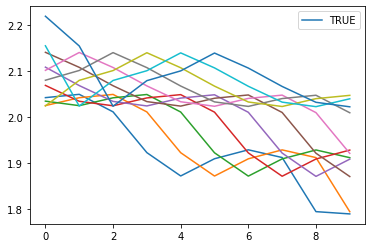

In [228]:
plt.plot(y_train[0:10], label = "TRUE")
plt.plot(X_train[0:10])
plt.legend()

In [229]:
import torch
import torch.nn as nn
import torch.optim as optim
# Define the batch size and number of batches
batch_size = 164
n_batch = len(X_train) // batch_size
n_init = X_train.shape[1]
# Define the neural network architecture
model = torch.nn.Sequential(
    torch.nn.Linear(n_init, 32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, 32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, 32), 
    torch.nn.ReLU(),
    torch.nn.Linear(32, 1)
)

# Define the loss function and optimizer
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), 
                             lr = 1e-5)

# Train the model
for epoch in range(300):
    # Shuffle the data
    perm = torch.randperm(len(X))
    X = X[perm]
    y = y[perm]

    # Loop over batches
    for i in range(n_batch):
        # Select a batch of data
        start = i * batch_size
        end = (i + 1) * batch_size
        X_batch = X_train[start:end]
        y_batch = y_train[start:end]

        # Forward pass
        y_pred = model(X_batch)

        # Compute the loss
        loss = criterion(y_pred, y_batch)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Compute and print the loss
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    print('Epoch {}, Loss: {:.4f}'.format(epoch+1, loss.item()))
    y_pred = model(X_test)
    loss_t = criterion(y_pred, y_test)
    print('Loss TEST: {:.4f}'.format( loss_t.item()))


Epoch 1, Loss: 0.8376
Loss TEST: 1.1796
Epoch 2, Loss: 0.8358
Loss TEST: 1.1779
Epoch 3, Loss: 0.8341
Loss TEST: 1.1762
Epoch 4, Loss: 0.8324
Loss TEST: 1.1744
Epoch 5, Loss: 0.8306
Loss TEST: 1.1726
Epoch 6, Loss: 0.8289
Loss TEST: 1.1708
Epoch 7, Loss: 0.8271
Loss TEST: 1.1690
Epoch 8, Loss: 0.8254
Loss TEST: 1.1671
Epoch 9, Loss: 0.8236
Loss TEST: 1.1653
Epoch 10, Loss: 0.8219
Loss TEST: 1.1635
Epoch 11, Loss: 0.8201
Loss TEST: 1.1616
Epoch 12, Loss: 0.8184
Loss TEST: 1.1598
Epoch 13, Loss: 0.8166
Loss TEST: 1.1579
Epoch 14, Loss: 0.8148
Loss TEST: 1.1561
Epoch 15, Loss: 0.8130
Loss TEST: 1.1543
Epoch 16, Loss: 0.8112
Loss TEST: 1.1524
Epoch 17, Loss: 0.8095
Loss TEST: 1.1506
Epoch 18, Loss: 0.8077
Loss TEST: 1.1487
Epoch 19, Loss: 0.8059
Loss TEST: 1.1469
Epoch 20, Loss: 0.8041
Loss TEST: 1.1450
Epoch 21, Loss: 0.8023
Loss TEST: 1.1431
Epoch 22, Loss: 0.8005
Loss TEST: 1.1413
Epoch 23, Loss: 0.7987
Loss TEST: 1.1394
Epoch 24, Loss: 0.7969
Loss TEST: 1.1375
Epoch 25, Loss: 0.7951
Lo

In [230]:
import matplotlib.pyplot as plt

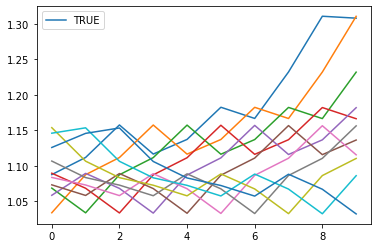

In [231]:
plt.plot(y_test[0:10], label = "TRUE")
plt.plot(X_test[0:10])
plt.legend()

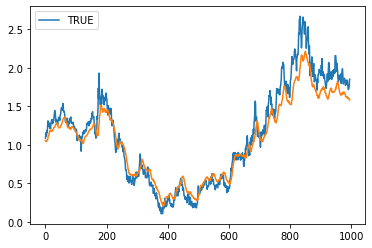

In [234]:
y_pred = model(X_test)
plt.plot(y_test.detach()[:], label = "TRUE")
plt.plot(y_pred.detach()[:])
plt.legend()

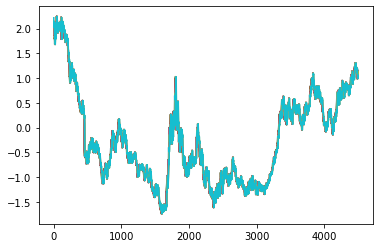

In [233]:
plt.plot(X_train)